한글 파일 구해서 아래 코드 참고하여 한글 도서 분류 모델 만들기.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk # 자연어 처리, 텍스트 처리작업 도구 모음.
import string
from collections import Counter 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC  # 분류와 앙상블 라이브러리.
from sklearn import metrics

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data.csv')
df.head()

,index,title,genre,summary
0,0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [ ]:
df.drop(columns = ['index'], inplace = True)

In [ ]:
df['genre'].value_counts()

thriller      1023
fantasy        876
science        647
history        600
horror         600
crime          500
romance        111
psychology     100
sports         100
travel         100
Name: genre, dtype: int64

[Text(0, 0, 'fantasy'),
 Text(1, 0, 'science'),
 Text(2, 0, 'crime'),
 Text(3, 0, 'history'),
 Text(4, 0, 'horror'),
 Text(5, 0, 'thriller'),
 Text(6, 0, 'psychology'),
 Text(7, 0, 'romance'),
 Text(8, 0, 'sports'),
 Text(9, 0, 'travel')]

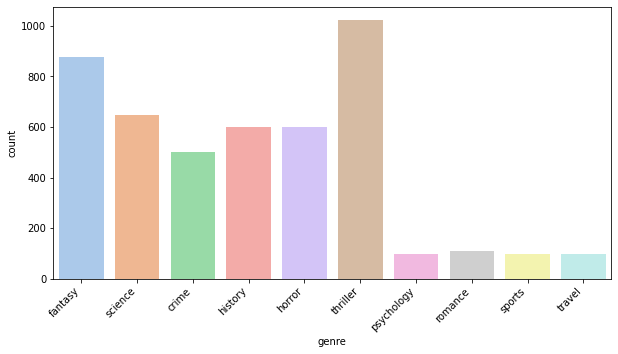

In [ ]:
plt.figure(figsize=(10,5))
chart = sns.countplot(x = df['genre'], palette = 'pastel', orient = 'h', )
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

In [ ]:
# 줄거리에서 내용과 상관 없는 내용 삭제.
def clean_text(text):
    text = str(text).lower() # Lowering the case
    text = re.sub('\[.*?\]', '', text) #Remove any text in the square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) # Remove any links present 
    text = re.sub('<.*?>+', '', text) # 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    text = re.sub('\n', '', text) # Removing the next line character
    text = re.sub('\w*\d\w*', '', text) # Removing the words contaitning numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    return text

In [ ]:
df['summary'] = df['summary'].apply(clean_text)

In [ ]:
# 텍스트 데이터 전처리
nltk.download('stopwords', download_dir='./')
nltk.download('wordnet', download_dir='./')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

[nltk_data] Downloading package stopwords to ./...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to ./...


In [ ]:
lemma = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    words = word_tokenize(text)
    words = [lemma.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    words = [stemmer.stem(word) for word in words]
    return " ".join(words)

In [ ]:
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
preprocess(df['summary'][0])

'drown wednesday first truste among morrow day arthur side wish fulfil appear leviathanwhal suffer gluttoni book begin leaf visit arthur discuss invit drown wednesday sent arthur admit hospit damag done leg attempt enter tuesday treasur tower suddenli hospit room becom flood water two transport border sea hous leaf snatch away larg ship green sail known fli manti arthur remain bed medallion given immort call marin appar fail summon help arthur without hope eventu buoy mark pirat elishar feverfew treasur float toward soon arthur open hand mark bloodi red colour arthur red hand feverfew mark whoever found treasur identifi later long scaveng ship call moth rescu arthur board arthur go name arth introduc sunscorch first mate captain catapillow journey bring line storm border sea later pursu feverfew ghostli ship shiver damag inflict moth seriou therefor sunscorch command upper hous sorcer dr scamandro open transfer portal elsewher secondari realm scamandro claim arthur carri someth interf 

In [ ]:
df['summary'] = df['summary'].apply(preprocess)

In [ ]:
df.head()

,title,genre,summary
0,Drowned Wednesday,fantasy,drown wednesday first truste among morrow day ...
1,The Lost Hero,fantasy,book open jason awaken school bu unabl rememb ...
2,The Eyes of the Overworld,fantasy,cugel easili persuad merchant fianosth attempt...
3,Magic's Promise,fantasy,book open heraldmag vanyel return countri vald...
4,Taran Wanderer,fantasy,taran gurgi return caer dallben follow event t...


In [ ]:
#장르분류 _ 라벨화

books_list = list(df['genre'].unique())
encode = [i for i in range(len(books_list))]
mapper = dict(zip(books_list, encode))
print(mapper)

{'fantasy': 0, 'science': 1, 'crime': 2, 'history': 3, 'horror': 4, 'thriller': 5, 'psychology': 6, 'romance': 7, 'sports': 8, 'travel': 9}


In [ ]:
df['genre'] = df['genre'].map(mapper)
df['genre'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
count_vec = CountVectorizer(max_df = 0.9, min_df = 2, max_features = 1000, stop_words = 'english')
bagofword_vec = count_vec.fit_transform(df['summary'])
bagofword_vec

<4657x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 304529 stored elements in Compressed Sparse Row format>

In [ ]:
test = df['genre']
X_train, X_test, y_train, y_test = train_test_split(bagofword_vec, test, test_size = 0.2)
X_train.shape,X_test.shape

((3725, 1000), (932, 1000))

In [ ]:
svc = SVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print(metrics.accuracy_score(y_test, svc_pred))

0.5740343347639485


In [ ]:
mb = MultinomialNB()
mb.fit(X_train, y_train)
mb_pred = mb.predict(X_test)
print(metrics.accuracy_score(y_test, mb_pred))

0.5912017167381974


In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(metrics.accuracy_score(y_test, rf.predict(X_test)))

0.5976394849785408


In [ ]:
# Using TF-IDF vectorizer

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['genre'])

X_train, X_test, y_train, y_test = train_test_split(df['summary'], y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape

((3725,), (932,))

In [ ]:
# Using tf-idf

tfidf_vectorizer = TfidfVectorizer(max_df = 0.8, max_features= 10000)
xtrain_tfidf = tfidf_vectorizer.fit_transform(X_train.values.astype('U'))
xtest_tfidf = tfidf_vectorizer.transform(X_test.values.astype('U'))

svc = SVC()
svc.fit(xtrain_tfidf, y_train)

SVC()

In [ ]:
svc_pred = svc.predict(xtest_tfidf)
print(metrics.accuracy_score(y_test, svc_pred))

0.6427038626609443


In [ ]:
mb = MultinomialNB()
mb.fit(xtrain_tfidf, y_train)
mb_pred = mb.predict(xtest_tfidf)
print(metrics.accuracy_score(y_test, mb_pred))

0.5203862660944206


In [ ]:
newmap = dict([(value, key) for key, value in mapper.items()])
newmap

{0: 'fantasy',
 1: 'science',
 2: 'crime',
 3: 'history',
 4: 'horror',
 5: 'thriller',
 6: 'psychology',
 7: 'romance',
 8: 'sports',
 9: 'travel'}

In [ ]:
CF = metrics.confusion_matrix(y_test, svc_pred)
CF

array([[149,   9,   0,   4,   6,  23,   0,   4,   0,   1],
       [  7,  87,   0,   7,   2,  16,   1,   0,   0,   0],
       [  2,   1,  52,   2,   1,  51,   0,   0,   0,   0],
       [  7,   6,   2,  88,   0,  13,   0,   0,   1,   1],
       [ 12,   4,   1,   5,  45,  46,   0,   0,   0,   0],
       [  6,   6,   3,   3,   6, 174,   0,   0,   0,   0],
       [  2,  18,   0,   0,   0,   6,   0,   0,   0,   0],
       [  4,   0,   0,   0,   0,  13,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0,   7,   0,   0,   4,   0],
       [  5,   2,   0,   8,   0,   7,   0,   0,   0,   0]])

In [ ]:
books_list

['fantasy',
 'science',
 'crime',
 'history',
 'horror',
 'thriller',
 'psychology',
 'romance',
 'sports',
 'travel']

In [ ]:
conf_df = pd.DataFrame(data = CF, index=books_list, columns=books_list)
conf_df

,fantasy,science,crime,history,horror,thriller,psychology,romance,sports,travel
fantasy,149,9,0,4,6,23,0,4,0,1
science,7,87,0,7,2,16,1,0,0,0
crime,2,1,52,2,1,51,0,0,0,0
history,7,6,2,88,0,13,0,0,1,1
horror,12,4,1,5,45,46,0,0,0,0
thriller,6,6,3,3,6,174,0,0,0,0
psychology,2,18,0,0,0,6,0,0,0,0
romance,4,0,0,0,0,13,0,0,0,0
sports,2,0,0,0,0,7,0,0,4,0
travel,5,2,0,8,0,7,0,0,0,0


<Axes: >

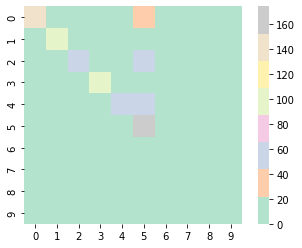

In [ ]:
sns.heatmap(CF, cmap = 'Pastel2', fmt = '.2g', xticklabels = list(mapper.values()), cbar = True, square = True)

In [ ]:
# 참고
# https://www.kaggle.com/code/deblina00/book-genre-prediction


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

In [ ]:
mcm = multilabel_confusion_matrix(np.array(y_test), np.array(svc_pred))
mcm = mcm.flatten().reshape(len(books_list), 4)
mcm = pd.DataFrame(data=mcm, columns=['TN', 'FP', 'FN', 'TP'], index=books_list)
mcm

,TN,FP,FN,TP
fantasy,689,47,47,149
science,766,46,33,87
crime,817,6,57,52
history,785,29,30,88
horror,804,15,68,45
thriller,552,182,24,174
psychology,905,1,26,0
romance,911,4,17,0
sports,918,1,9,4
travel,908,2,22,0
